In [1]:
import math
import numpy as np
import wandb
import pickle
import os
import shapely.wkt as wkt
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
from torch_geometric.transforms import LineGraph

import gzip
import xml.etree.ElementTree as ET

import torch
import torch_geometric
from torch_geometric.data import Data

import processing_io as pio
import sys
import os
import joblib
import json

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from shapely.geometry import Point, LineString, box
from matplotlib.colors import TwoSlopeNorm

from shapely.ops import unary_union
from mpl_toolkits.axes_grid1 import make_axes_locatable
from torch_geometric.data import Data, Batch
import torch
from torch_geometric.data import Data
import help_functions as hf

districts = gpd.read_file("../../data/visualisation/districts_paris.geojson")

# Add the 'scripts' directory to the Python path
scripts_path = os.path.abspath(os.path.join('..'))
if scripts_path not in sys.path:
    sys.path.append(scripts_path)

import gnn_io as gio
import gnn_architectures as garch

# Assuming 'highway_mapping' and 'encode_modes' are defined as in your context
highway_mapping = {
    'residential': 0, 'tertiary': 1, 'living_street': 2, 'secondary': 3, 
    'primary': 4, 'trunk_link': 5, 'primary_link': 6, 'motorway': 7, 
    'service': 8, 'unclassified': 9, 'secondary_link': 10, 
    'pedestrian': 11, 'trunk': 12, 'motorway_link': 13, 
    'construction': 14, 'tertiary_link': 15, np.nan: -1
}

In [2]:
# Parameters to define
run_path = '/home/enatterer/Development/gnn_predicting_effects_of_traffic_policies/data/runs_y_normalized_robust_scaler/hidden_64_hidden_layer_str_[64]_/'
model_path = run_path +  'trained_model/model.pth'
data_created_during_training = run_path + 'data_created_during_training/'
indices_of_datasets_to_use = [0, 1, 3, 4]

scaler_y = joblib.load(data_created_during_training + 'y_scaler.pkl')
scaler_x = joblib.load(data_created_during_training + 'x_scaler.pkl')
scaler_pos = joblib.load(data_created_during_training + 'pos_scaler.pkl')

# Load the test dataset created during training
test_set_dl = torch.load(data_created_during_training + 'test_dl.pt')

# Load the DataLoader parameters
with open(data_created_during_training + 'test_loader_params.json', 'r') as f:
    test_set_dl_loader_params = json.load(f)
    
# Remove or correct collate_fn if it is incorrectly specified
if 'collate_fn' in test_set_dl_loader_params and isinstance(test_set_dl_loader_params['collate_fn'], str):
    del test_set_dl_loader_params['collate_fn']  # Remove it to use the default collate function
    
test_set_loader = torch.utils.data.DataLoader(test_set_dl, **test_set_dl_loader_params)

In [3]:
len(test_set_loader.dataset)

734

In [4]:
test_data = "../../data/test_data/gdf_pop_1pm_policy_in_1_2_3_4.geojson"
test_data = gpd.read_file(test_data)
base_case = "../../data/test_data/gdf_basecase_mean_pop_1pm.geojson"
base_case = gpd.read_file(base_case)

In [11]:
test_data.head()

link   from_node     to_node     length  freespeed  capacity  lanes  \
0  100315    24972409    24972408  16.181257   8.333333     480.0    1.0   
1  100316  5904976363    24983651  14.860209   8.333333     480.0    1.0   
2  100317    24983651  5904976363  14.860209   8.333333     960.0    2.0   
3  100321   664205947    24972376  22.264540   8.333333     960.0    2.0   
4  100324    24972376    24972375  64.853276   8.333333     480.0    1.0   

                      modes  vol_car  storageCapacityUsedInQsim      highway  \
0     bus,car,car_passenger      6.9                        NaN  residential   
1  bus,car,car_passenger,pt      7.9                        NaN     tertiary   
2  bus,car,car_passenger,pt      1.2                        NaN     tertiary   
3         car,car_passenger      6.1                        NaN  residential   
4     bus,car,car_passenger      7.1                        NaN  residential   

                                            geometry  
0  LINESTRING (651473.30416 6861511.11045, 651457...  
1  LINESTRING (651477.81786 6861578.65908, 651475...  
2  LINESTRING (651475.67670 6861563.95433, 651477...  
3  LINESTRING (651565.07842 6861531.47026, 651559...  
4  LINESTRING (651559.38742 6861509.94534, 651502...

In [5]:
# Example of how to initialize your model
in_channels = 6  # Example value
out_channels = 1  # Example value
hidden_layers_base_for_point_net_conv = 64
hidden_layer_structure = [64]  # Example value

# Initialize the model
model = garch.MyGnn(in_channels=in_channels, out_channels=out_channels, hidden_layers_base_for_point_net_conv=hidden_layers_base_for_point_net_conv, hidden_layer_structure=hidden_layer_structure)

# Load the model state dictionary
model.load_state_dict(torch.load(model_path))

Initializing PointNetConv(local_nn=Sequential(
  (0): Linear(in_features=6, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
), global_nn=Sequential(
  (0): Linear(in_features=64, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=64, bias=True)
))
Initializing 0.weight with kaiming_normal
Initializing 0.bias with zeros
Initializing 2.weight with kaiming_normal
Initializing 2.bias with zeros
Initializing 0.weight with kaiming_normal
Initializing 0.bias with zeros
Initializing 2.weight with kaiming_normal
Initializing 2.bias with zeros
Initializing 4.weight with kaiming_normal
Initializing 4.bias with zeros
Initializing Linear(in_features=6, out_features=64, bias=True)
Initializing Linear(in_features=64, out_features=64, bias=True)
Initializing Linear(in_features=64, out_features=32, bias=True)
Initializing Linear(in_features=32, 

<All keys matched successfully>

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_fct = torch.nn.MSELoss()

test_loss, r_squared, actual_vals, predictions = hf.validate_trained_model(model, test_set_loader.dataset, loss_fct, device)
print(f'Test Loss: {test_loss}')
print(f'r_squared: {r_squared}')
print(f'actual_vals shape: {len(actual_vals)}')
print(f'predictions shape: {len(predictions)}')

Test Loss: 4.366352123850373
r_squared: 0.2695990204811096
actual_vals shape: 734
predictions shape: 734


/home/enatterer/Development/gnn_predicting_effects_of_traffic_policies/scripts/testing_and_evaluation/help_functions.py:198: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  alpha_shape_gs.plot(ax=ax, edgecolor='black', linewidth=2, facecolor='None', zorder=2, label = 'Capacity was decreased in this section')


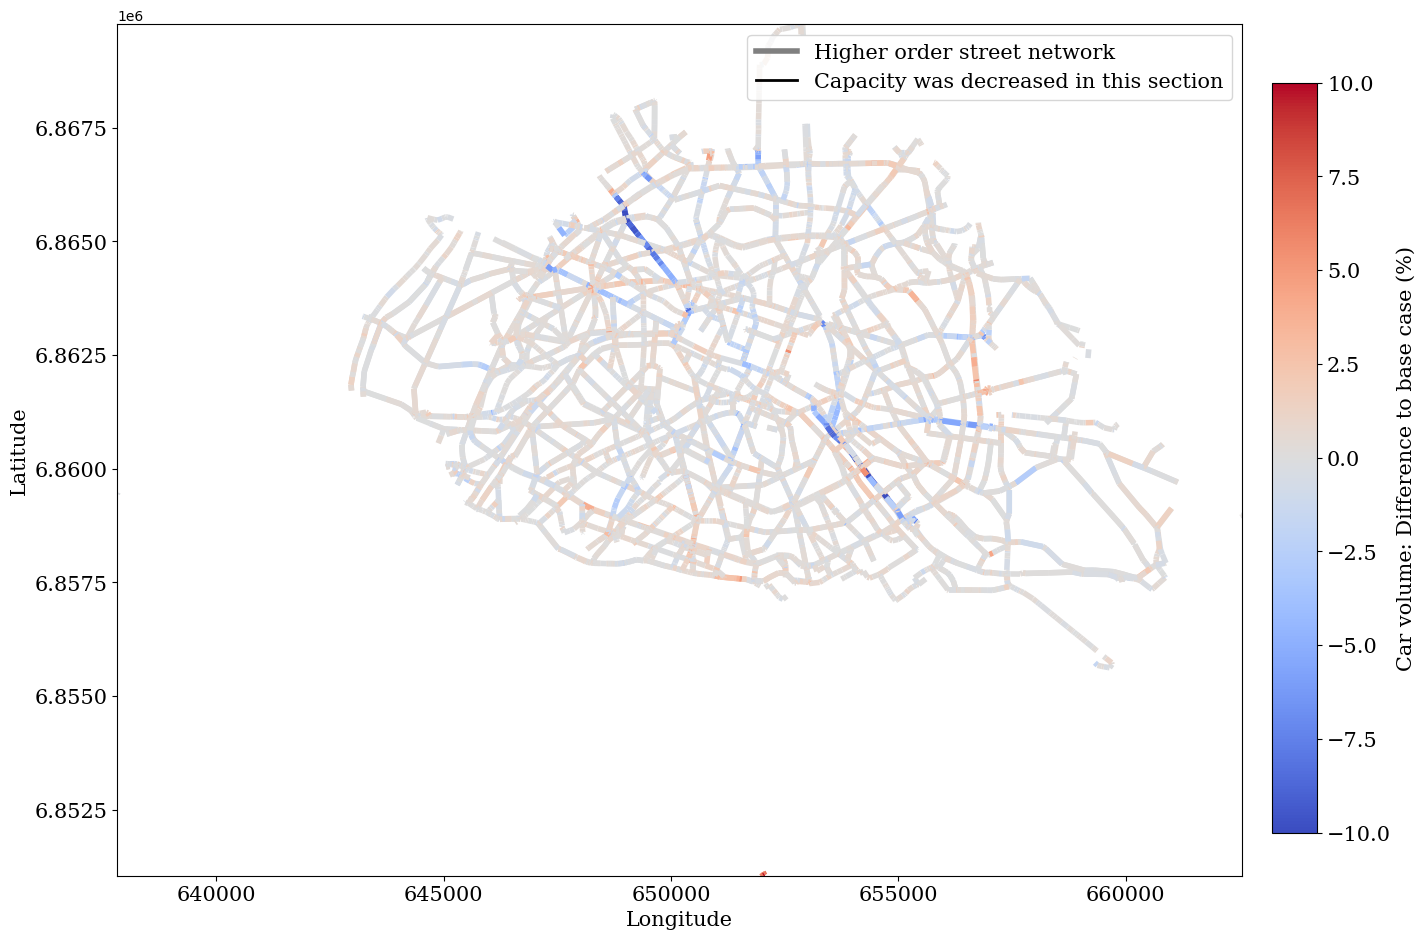

/home/enatterer/Development/gnn_predicting_effects_of_traffic_policies/scripts/testing_and_evaluation/help_functions.py:198: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  alpha_shape_gs.plot(ax=ax, edgecolor='black', linewidth=2, facecolor='None', zorder=2, label = 'Capacity was decreased in this section')


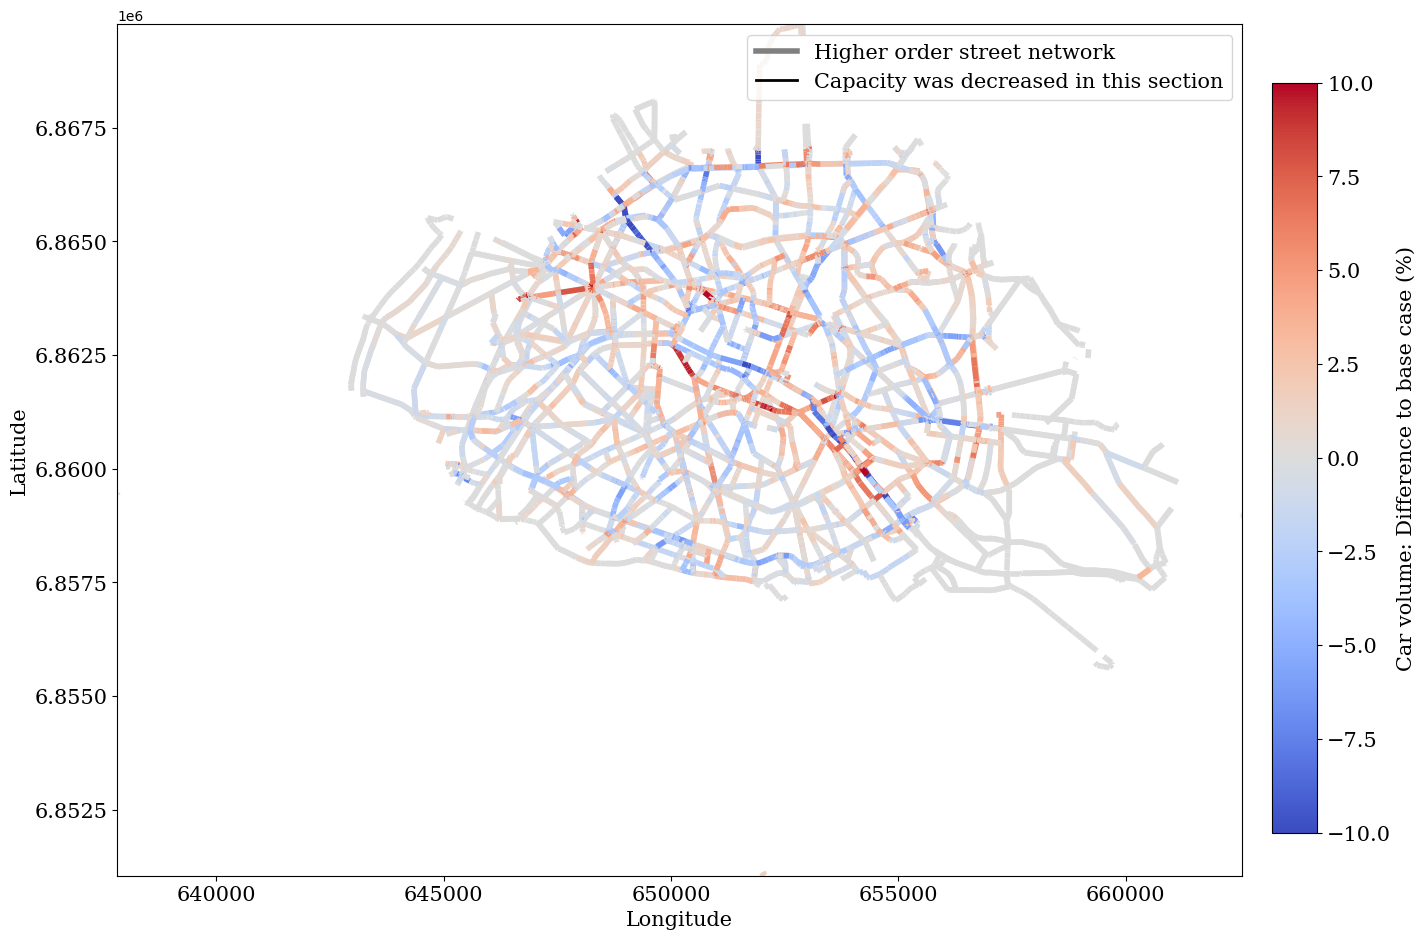

/home/enatterer/Development/gnn_predicting_effects_of_traffic_policies/scripts/testing_and_evaluation/help_functions.py:276: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  alpha_shape_gs.plot(ax=ax, edgecolor='black', linewidth=2, facecolor='None', zorder=2, label='Capacity was decreased in this section')


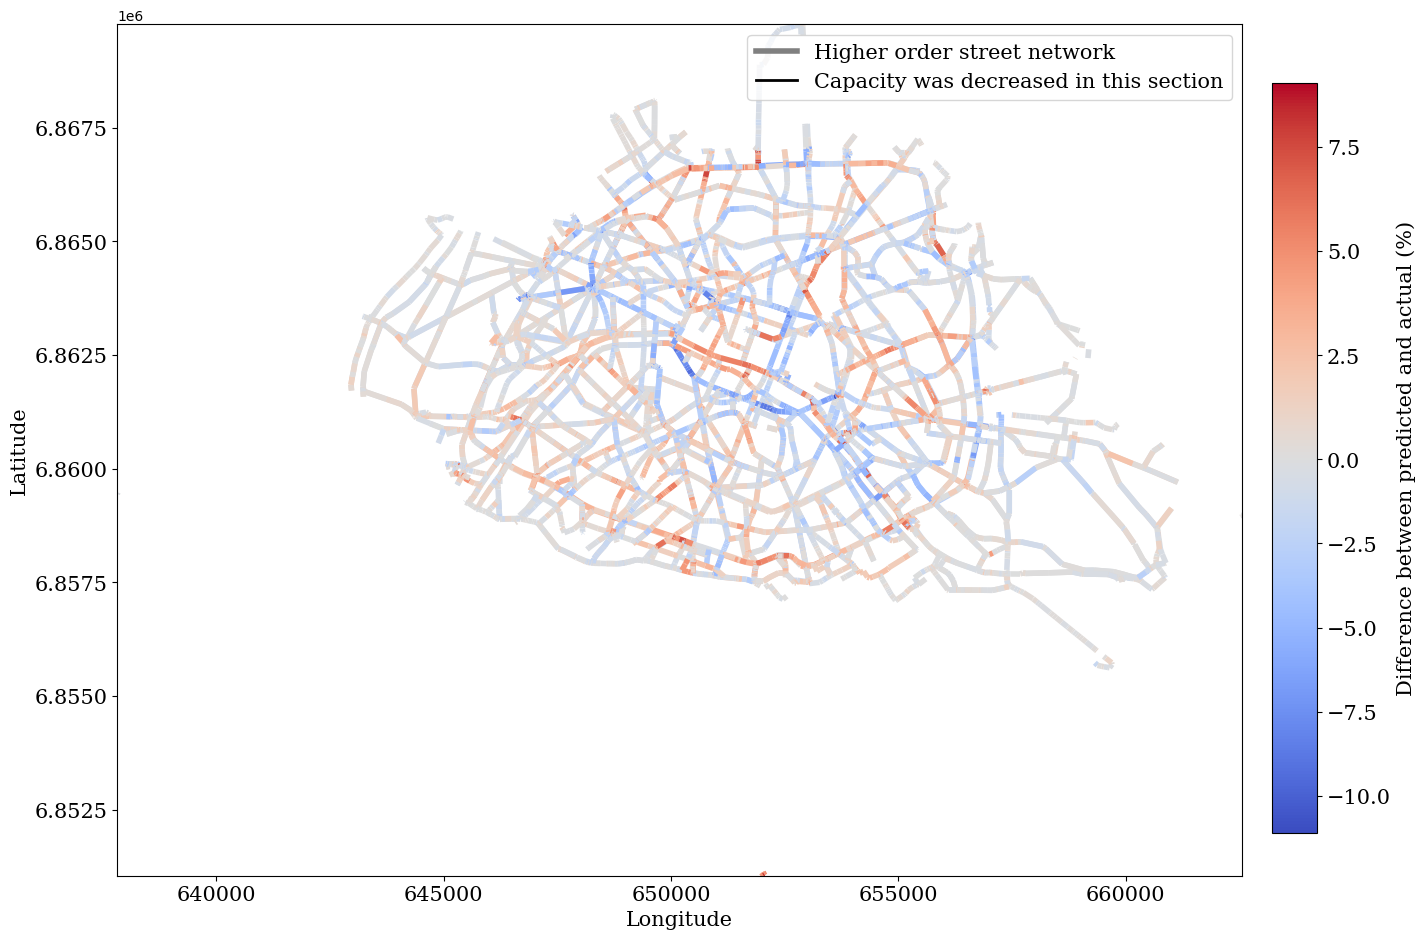

/home/enatterer/Development/gnn_predicting_effects_of_traffic_policies/scripts/testing_and_evaluation/help_functions.py:198: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  alpha_shape_gs.plot(ax=ax, edgecolor='black', linewidth=2, facecolor='None', zorder=2, label = 'Capacity was decreased in this section')


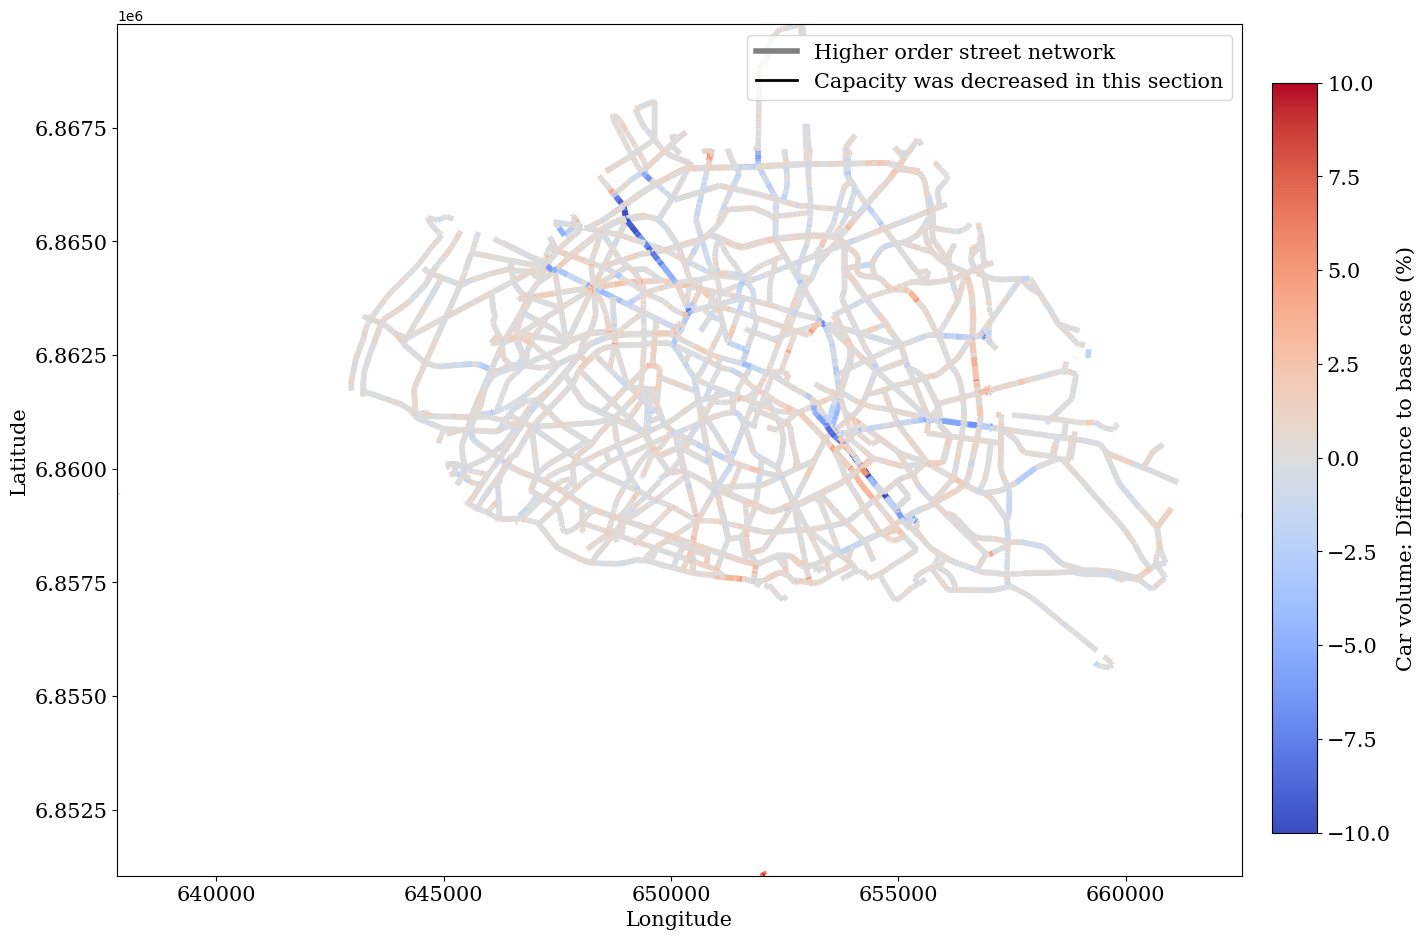

/home/enatterer/Development/gnn_predicting_effects_of_traffic_policies/scripts/testing_and_evaluation/help_functions.py:198: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  alpha_shape_gs.plot(ax=ax, edgecolor='black', linewidth=2, facecolor='None', zorder=2, label = 'Capacity was decreased in this section')


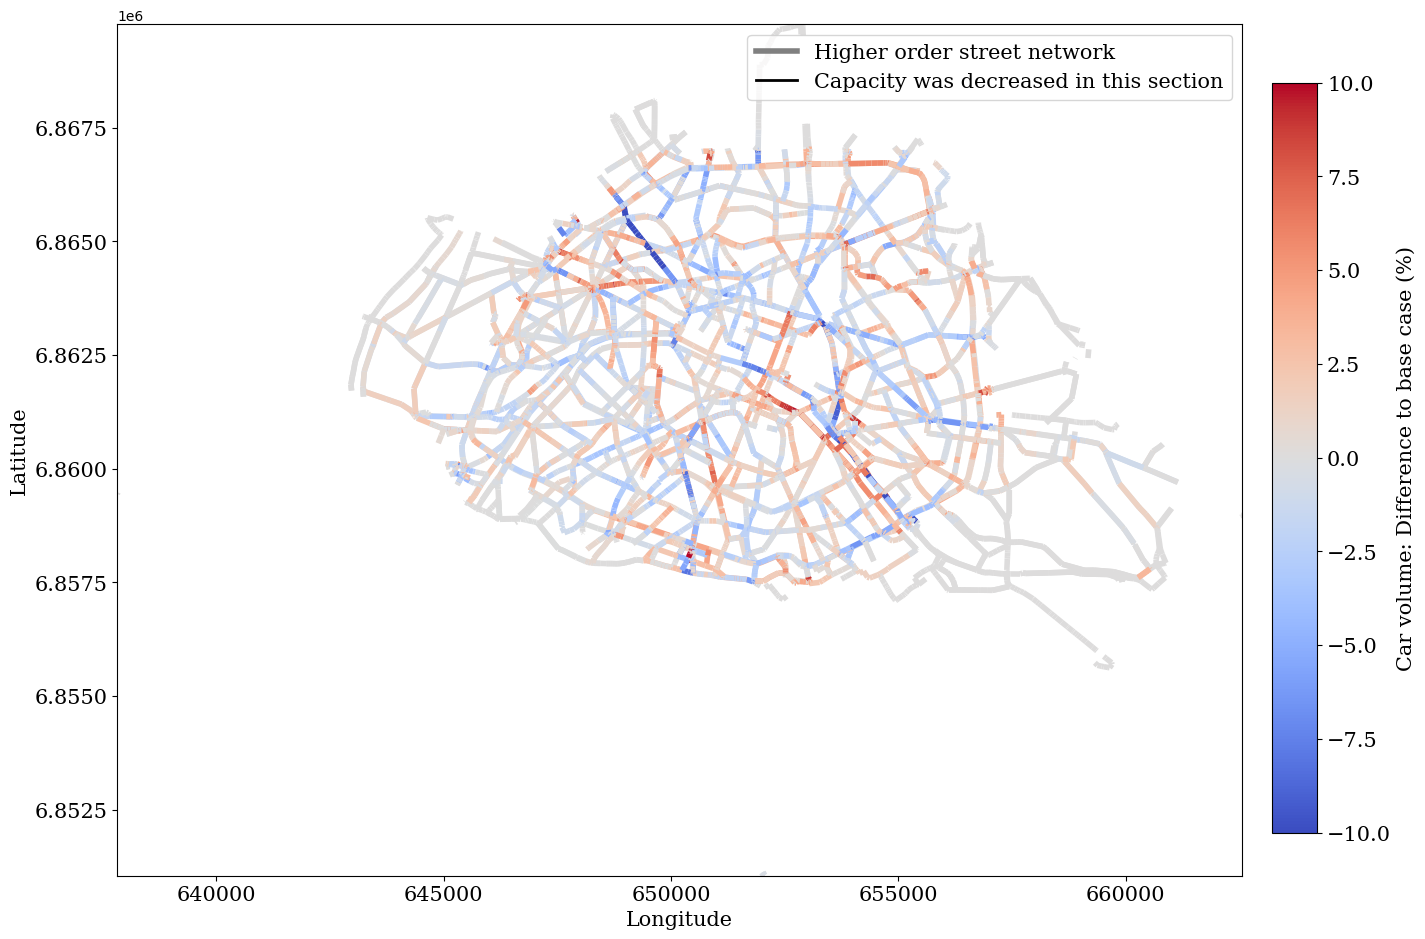

/home/enatterer/Development/gnn_predicting_effects_of_traffic_policies/scripts/testing_and_evaluation/help_functions.py:276: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  alpha_shape_gs.plot(ax=ax, edgecolor='black', linewidth=2, facecolor='None', zorder=2, label='Capacity was decreased in this section')


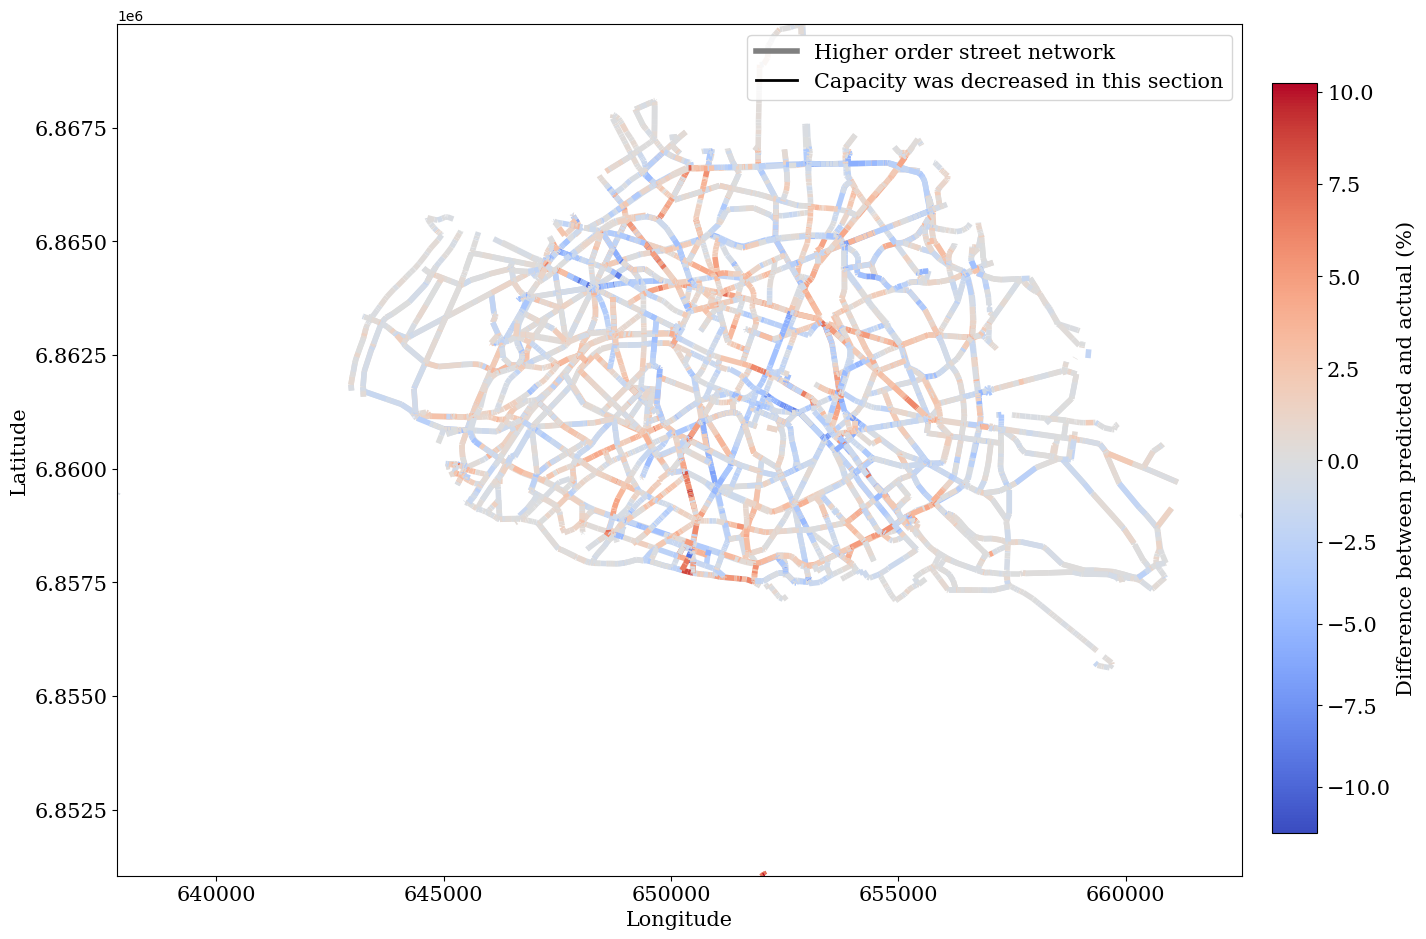

/home/enatterer/Development/gnn_predicting_effects_of_traffic_policies/scripts/testing_and_evaluation/help_functions.py:198: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  alpha_shape_gs.plot(ax=ax, edgecolor='black', linewidth=2, facecolor='None', zorder=2, label = 'Capacity was decreased in this section')


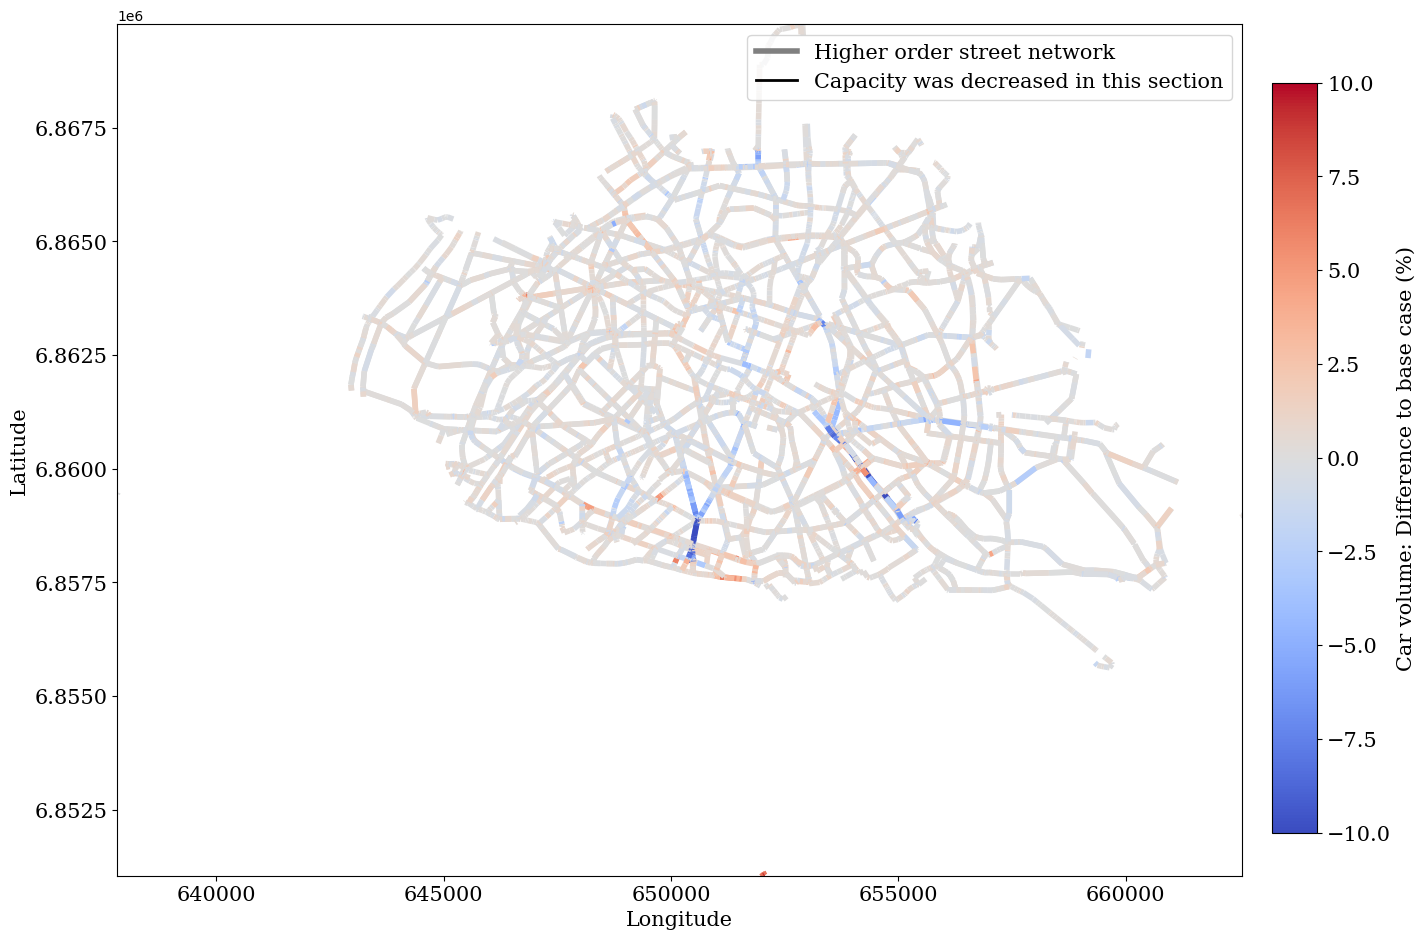

/home/enatterer/Development/gnn_predicting_effects_of_traffic_policies/scripts/testing_and_evaluation/help_functions.py:198: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  alpha_shape_gs.plot(ax=ax, edgecolor='black', linewidth=2, facecolor='None', zorder=2, label = 'Capacity was decreased in this section')


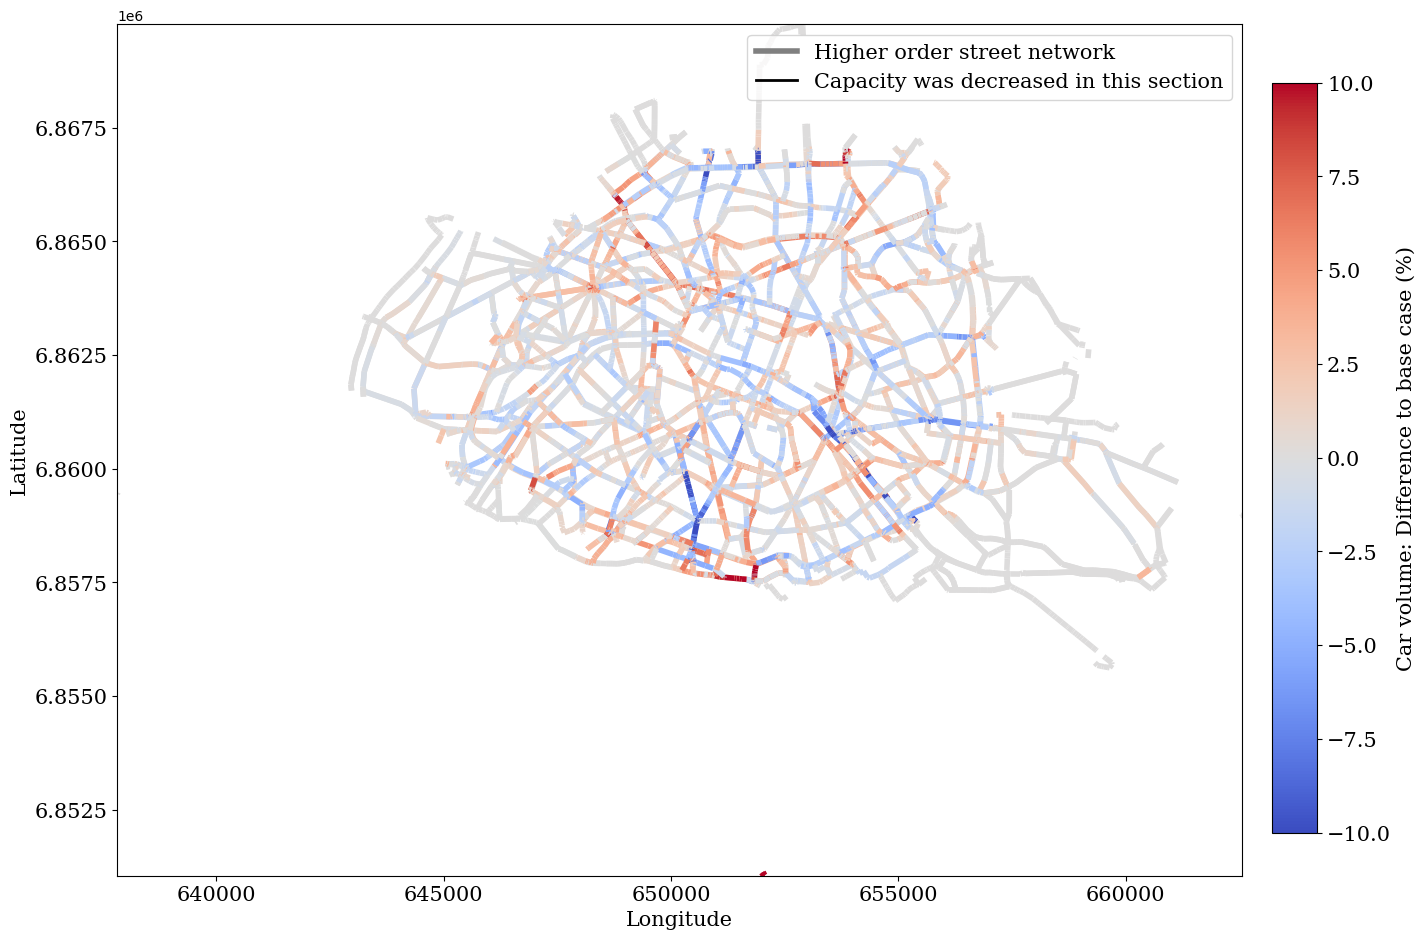

/home/enatterer/Development/gnn_predicting_effects_of_traffic_policies/scripts/testing_and_evaluation/help_functions.py:276: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  alpha_shape_gs.plot(ax=ax, edgecolor='black', linewidth=2, facecolor='None', zorder=2, label='Capacity was decreased in this section')


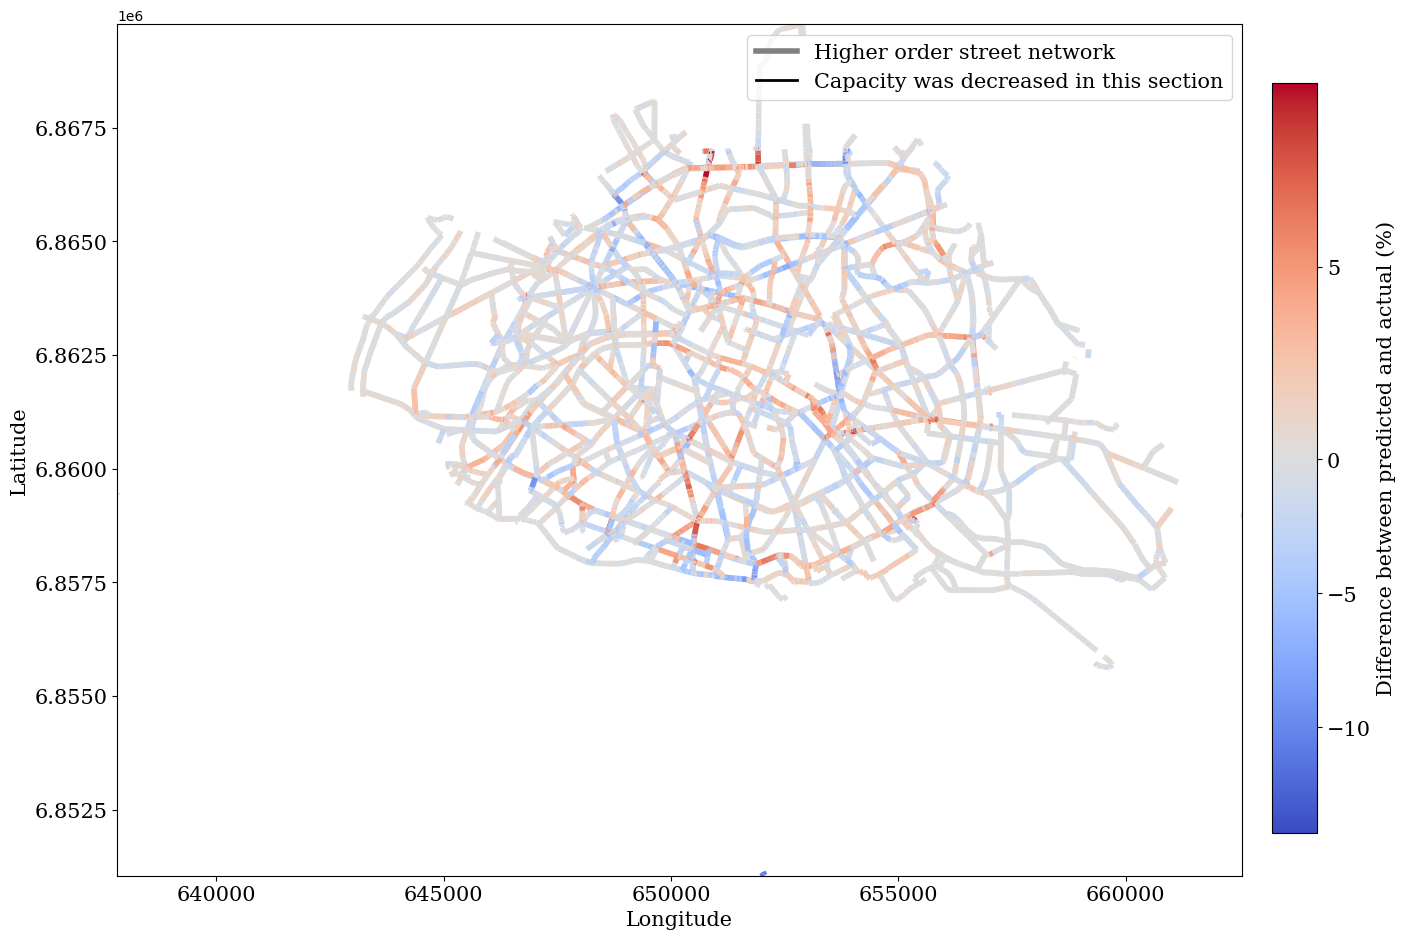

/home/enatterer/Development/gnn_predicting_effects_of_traffic_policies/scripts/testing_and_evaluation/help_functions.py:198: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  alpha_shape_gs.plot(ax=ax, edgecolor='black', linewidth=2, facecolor='None', zorder=2, label = 'Capacity was decreased in this section')


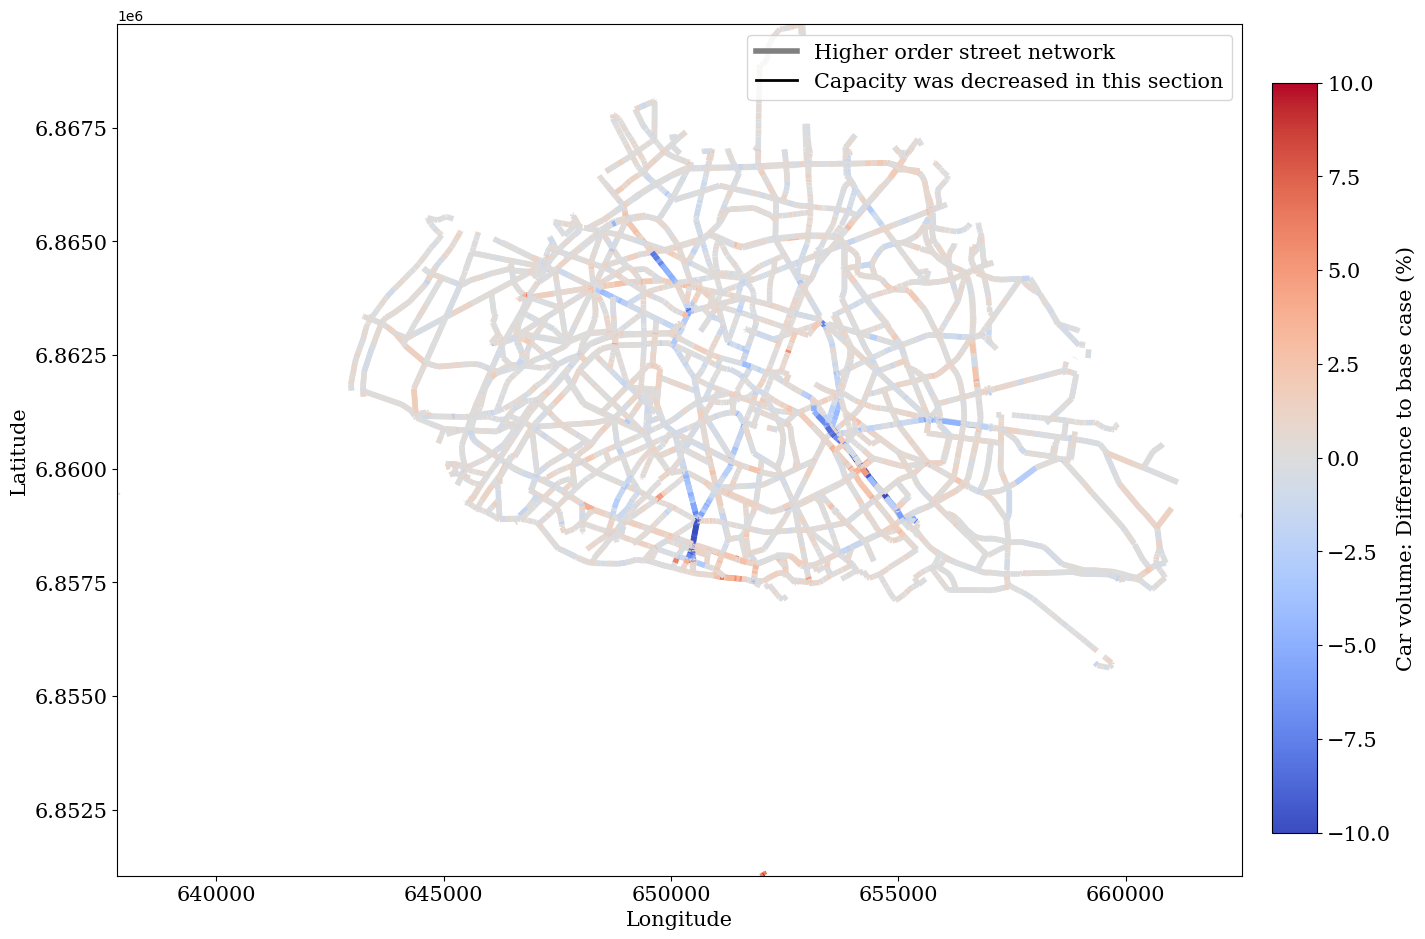

/home/enatterer/Development/gnn_predicting_effects_of_traffic_policies/scripts/testing_and_evaluation/help_functions.py:198: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  alpha_shape_gs.plot(ax=ax, edgecolor='black', linewidth=2, facecolor='None', zorder=2, label = 'Capacity was decreased in this section')


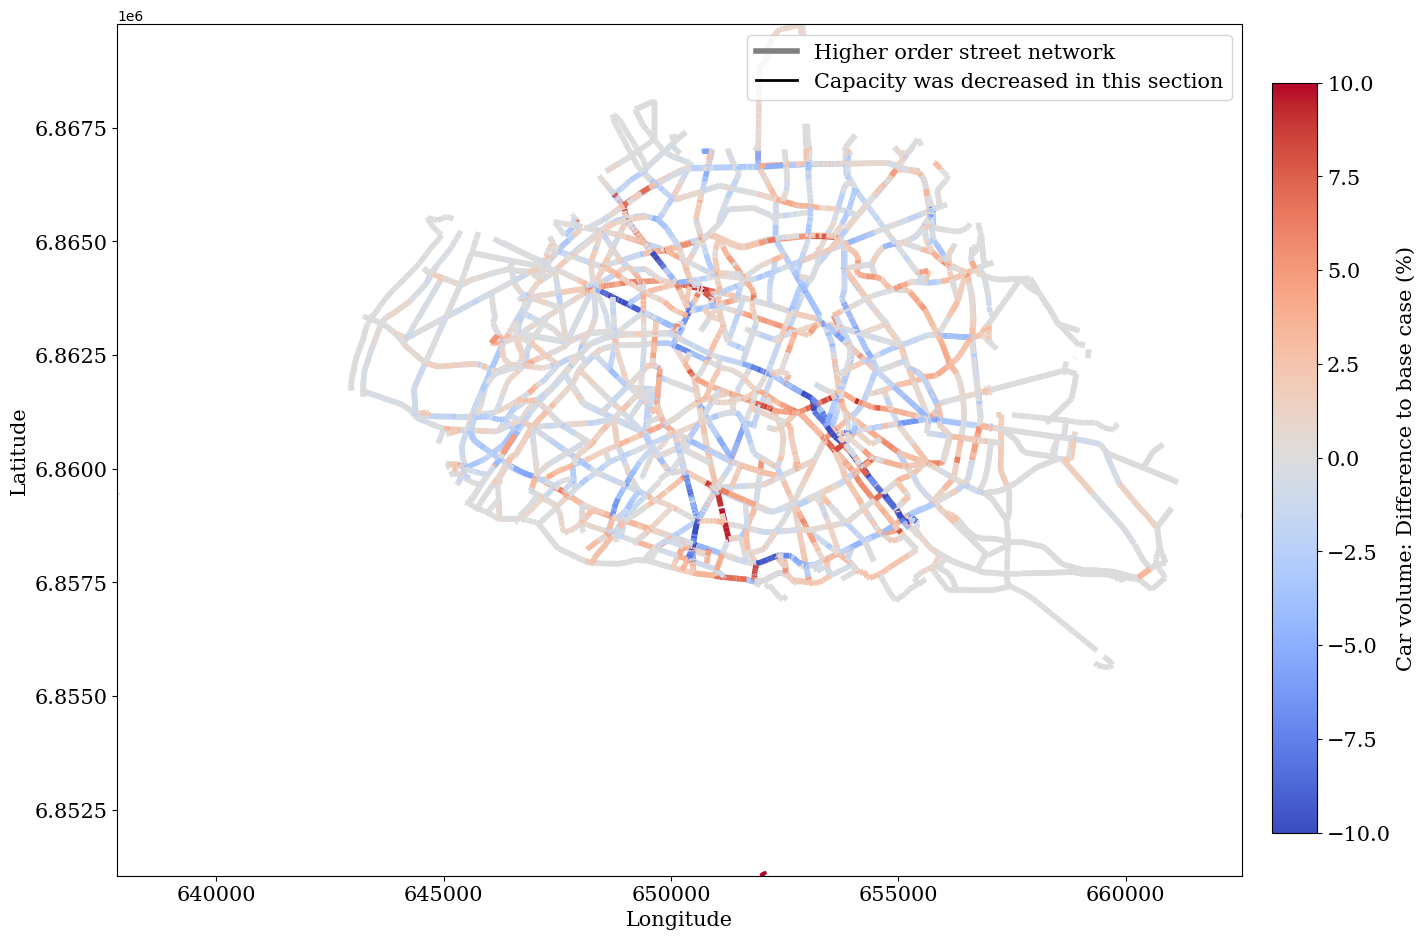

/home/enatterer/Development/gnn_predicting_effects_of_traffic_policies/scripts/testing_and_evaluation/help_functions.py:276: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  alpha_shape_gs.plot(ax=ax, edgecolor='black', linewidth=2, facecolor='None', zorder=2, label='Capacity was decreased in this section')


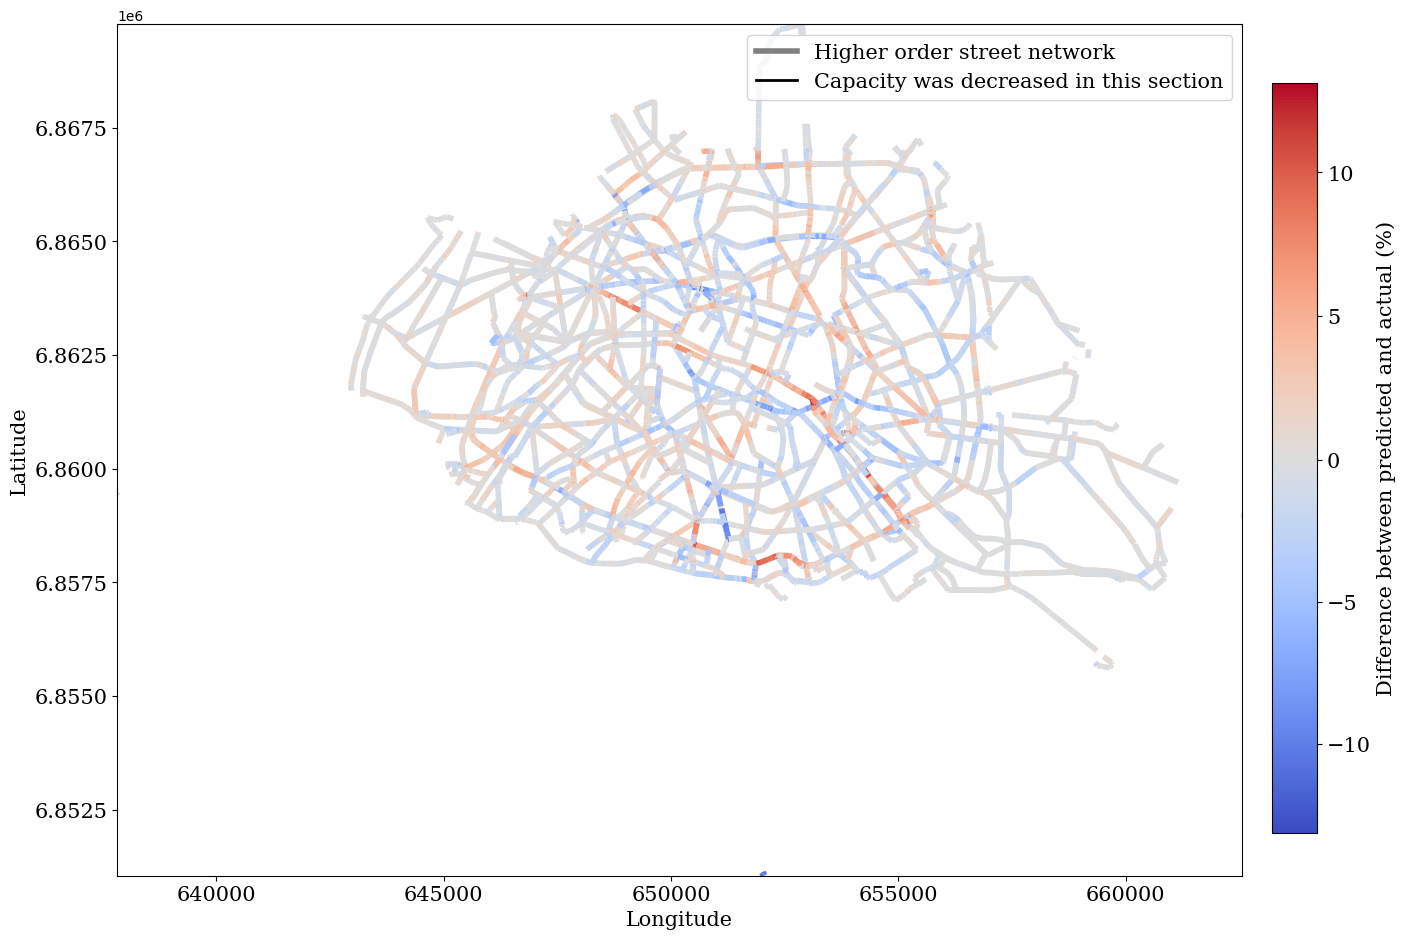

/home/enatterer/Development/gnn_predicting_effects_of_traffic_policies/scripts/testing_and_evaluation/help_functions.py:198: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  alpha_shape_gs.plot(ax=ax, edgecolor='black', linewidth=2, facecolor='None', zorder=2, label = 'Capacity was decreased in this section')


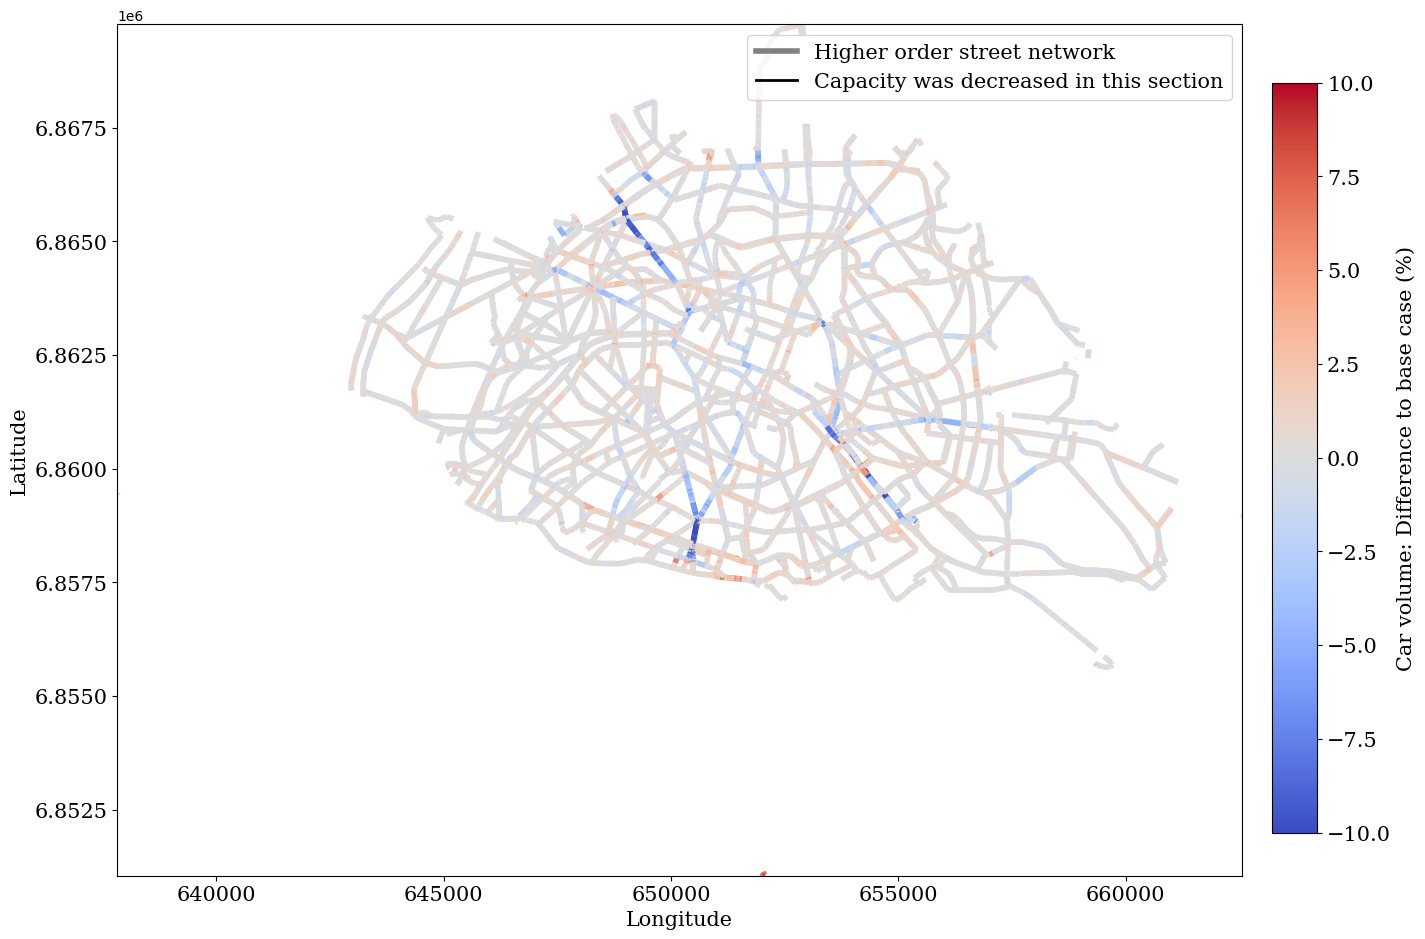

/home/enatterer/Development/gnn_predicting_effects_of_traffic_policies/scripts/testing_and_evaluation/help_functions.py:198: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  alpha_shape_gs.plot(ax=ax, edgecolor='black', linewidth=2, facecolor='None', zorder=2, label = 'Capacity was decreased in this section')


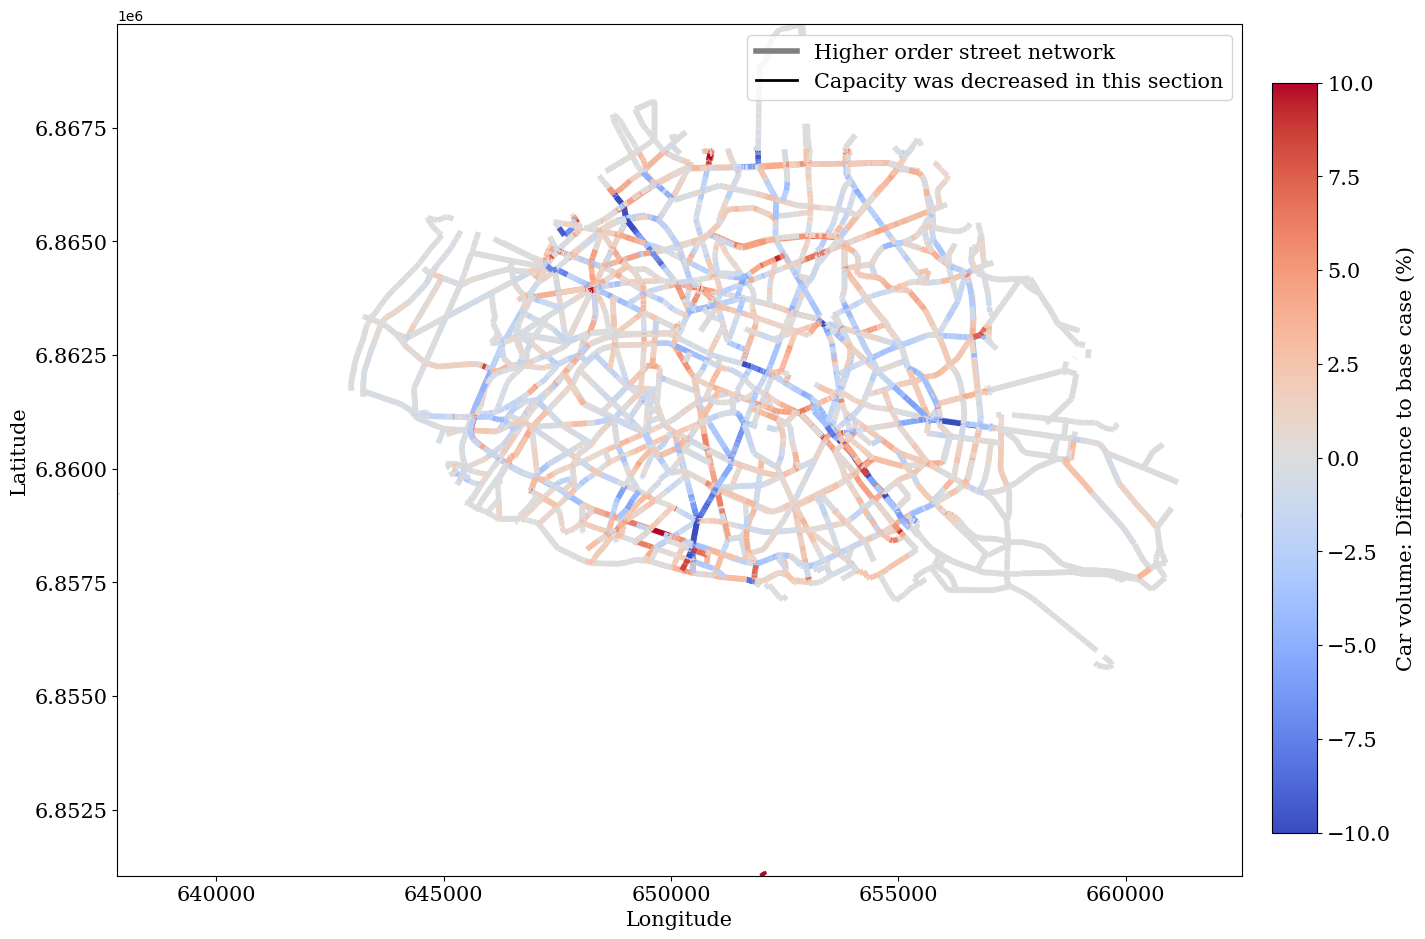

/home/enatterer/Development/gnn_predicting_effects_of_traffic_policies/scripts/testing_and_evaluation/help_functions.py:276: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  alpha_shape_gs.plot(ax=ax, edgecolor='black', linewidth=2, facecolor='None', zorder=2, label='Capacity was decreased in this section')


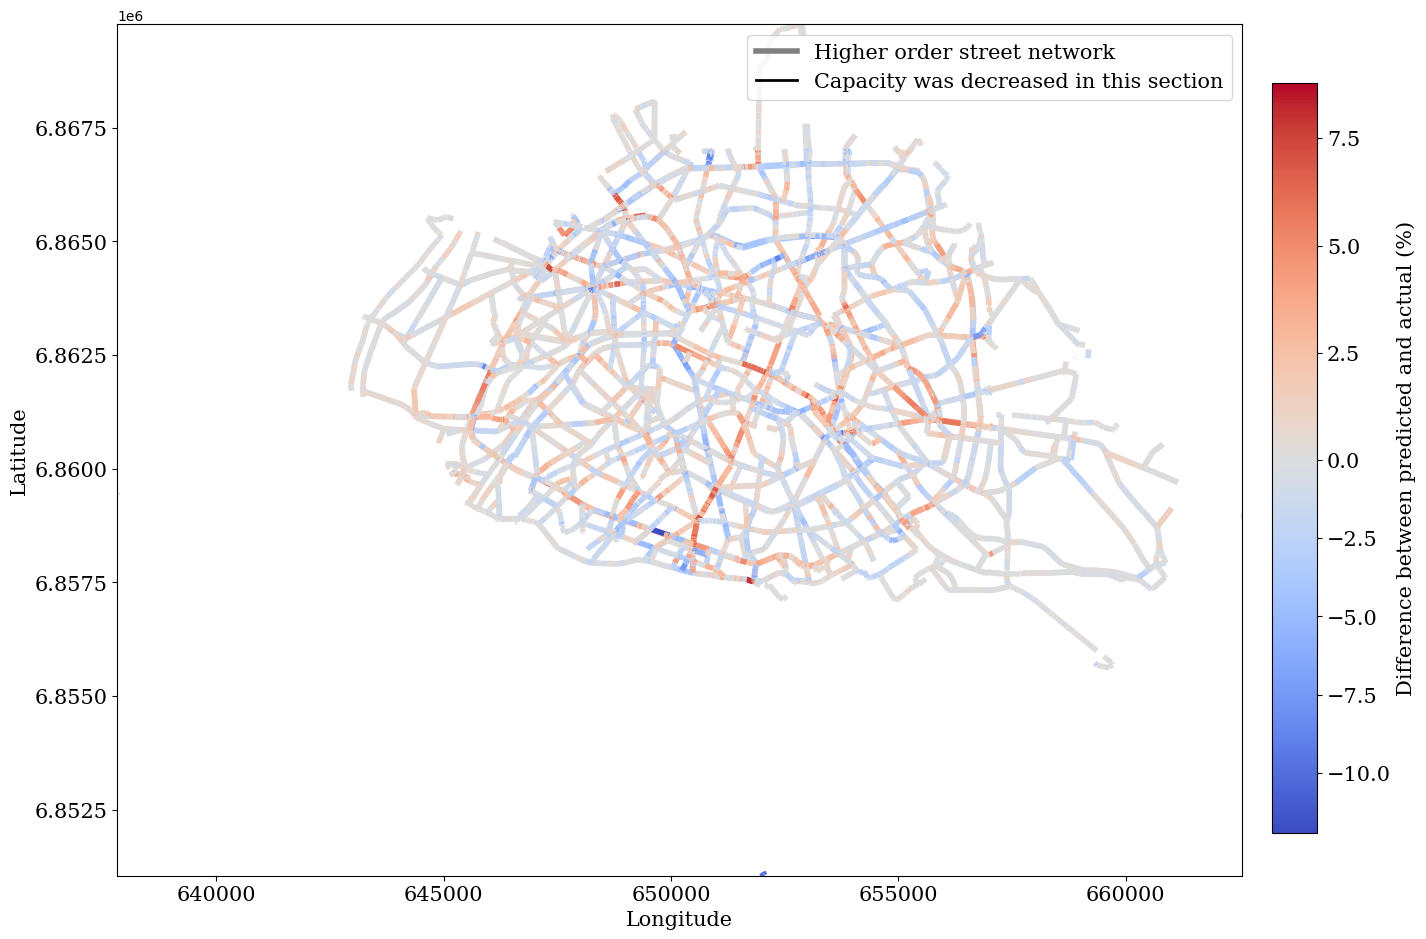

In [13]:
for i in range(5):
    gdf = hf.data_to_geodataframe(data=test_set_loader.dataset[i], original_gdf=test_data, predicted_values=predictions[i])
    gdf_with_og_values = hf.map_to_original_values(input_gdf=gdf, scaler_x=scaler_x, scaler_y = scaler_y)
    hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="og_vol_car_change_predicted", save_it=False, number_to_plot=1, is_predicted=True,alpha=200)
    hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="og_vol_car_change_actual", save_it=False, number_to_plot=1, is_predicted=False,alpha=200)
    hf.plot_difference_output(gdf_input=gdf_with_og_values, column1="og_vol_car_change_predicted", column2="og_vol_car_change_actual", save_it=False, number_to_plot=1)

In [9]:
# dataset = test_set_loader.dataset

# # Select the device (CPU in this example)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Move reference values to the same device
# reference_x_column = dataset[0].x[:, 2].to(device)
# reference_y = dataset[0].y.to(device)

# # Initialize flags to check if all values are the same
# all_x_columns_same = True
# all_y_same = True

# # Iterate through the dataset
# for data in test_set_loader.dataset:
#     # Move data to the same device
#     data_x_column = data.x[:, 2].to(device)
#     data_y = data.y.to(device)
    
#     # Compare the third column of x values
#     if not torch.equal(data_x_column, reference_x_column):
#         all_x_columns_same = False

#     # Compare the y values
#     if not torch.equal(data_y, reference_y):
#         all_y_same = False

#     # Break early if both are found to be different
#     if not all_x_columns_same and not all_y_same:
#         break

# # Print results
# print(f"All third columns of x are the same: {all_x_columns_same}")
# print(f"All y values are the same: {all_y_same}")